# Temporal Dynamics Analysis - Full Window Baseline

**Purpose**: Analyze ALL pupil and gaze features across the full PRE-decision window (-2s to 0s) to establish a baseline for comparison with within-window temporal analysis.

**Method**: 
- Use the already-extracted features (full window aggregates)
- Compare INVEST vs KEEP decisions
- Statistical tests (t-tests, Cohen's d effect sizes)

**Key Question**: Which features show the strongest divergence when aggregated over the full PRE-decision window?

**Note**: This serves as a baseline for the within-window temporal dynamics analysis which breaks down the window into 500ms bins.

In [22]:
# ============================================================================
# CONFIGURATION: Set timeframe for analysis
# ============================================================================
TIMEFRAME = 'PRE'  # Options: 'PRE', 'POST'
# ============================================================================

print(f"\n{'='*70}")
print(f"TEMPORAL DYNAMICS ANALYSIS: {TIMEFRAME}-DECISION PERIOD")
print(f"{'='*70}\n")


TEMPORAL DYNAMICS ANALYSIS: PRE-DECISION PERIOD



In [23]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from scipy import stats

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 11

## Load PRE-Decision Features

In [24]:
# Load PRE-decision features
with open(f'../../data/results/features_{TIMEFRAME}/extracted_features_{TIMEFRAME}.pkl', 'rb') as f:
    feature_data = pickle.load(f)

data_pre = feature_data['merged_df']

print(f"PRE-decision data: {len(data_pre)} trials")
print(f"Subjects: {data_pre['subject_id'].nunique()}")
print(f"\nOutcome distribution:")
print(data_pre['outcome'].value_counts())

PRE-decision data: 12511 trials
Subjects: 97

Outcome distribution:
outcome
1    8238
0    4273
Name: count, dtype: int64


## Compare Feature Distributions by Outcome

We'll analyze how {TIMEFRAME}-decision features differ between INVEST vs KEEP choices.

In [25]:
# Separate by outcome
invest_trials = data_pre[data_pre['outcome'] == 1]
keep_trials = data_pre[data_pre['outcome'] == 0]

print(f"INVEST trials: {len(invest_trials)}")
print(f"KEEP trials: {len(keep_trials)}")

INVEST trials: 8238
KEEP trials: 4273


## ALL Pupil Features Comparison

Analyzing all available pupil/physiology features to match the within-window temporal analysis.

In [26]:
# ALL pupil/physiology features (matching within-window analysis)
pupil_features = [
    'pupil_mean_pre',
    'pupil_std_pre', 
    'pupil_slope_pre',
    'time_to_peak_pre',
    'pupil_cv_pre',
    'pupil_velocity_mean_pre',
    'pupil_max_dilation_rate_pre',
    'pupil_max_constriction_rate_pre',
    'pupil_acceleration_std_pre',
    'pct_time_dilating_pre',
    'num_dilation_peaks_pre',
    'eye_asymmetry_pre',
    'eye_asymmetry_std_pre',
]

def compute_cohens_d(group1, group2):
    """Compute Cohen's d effect size."""
    n1, n2 = len(group1), len(group2)
    var1, var2 = group1.var(), group2.var()
    pooled_std = np.sqrt(((n1-1)*var1 + (n2-1)*var2) / (n1+n2-2))
    if pooled_std == 0:
        return 0
    return (group1.mean() - group2.mean()) / pooled_std

# Compute statistics for all pupil features
comparison_results = []

for feature in pupil_features:
    if feature not in data_pre.columns:
        print(f"Warning: {feature} not found in data")
        continue
        
    invest_vals = invest_trials[feature].dropna()
    keep_vals = keep_trials[feature].dropna()
    
    if len(invest_vals) < 10 or len(keep_vals) < 10:
        continue
    
    # T-test
    t_stat, p_val = stats.ttest_ind(invest_vals, keep_vals)
    
    # Effect size (Cohen's d)
    cohens_d = compute_cohens_d(invest_vals, keep_vals)
    
    comparison_results.append({
        'feature': feature.replace('_pre', ''),  # Clean name for display
        'feature_full': feature,  # Full column name for data access
        'invest_mean': invest_vals.mean(),
        'keep_mean': keep_vals.mean(),
        'difference': invest_vals.mean() - keep_vals.mean(),
        't_statistic': t_stat,
        'p_value': p_val,
        'cohens_d': cohens_d,
        'abs_cohens_d': abs(cohens_d),
        'significant': p_val < 0.05,
        'significant_bonferroni': p_val < (0.05 / len(pupil_features))
    })

pupil_comparison_df = pd.DataFrame(comparison_results)
pupil_comparison_df = pupil_comparison_df.sort_values('abs_cohens_d', ascending=False)

print("\n" + "="*100)
print("ALL PUPIL FEATURES: INVEST vs KEEP (Full PRE-decision window: -2s to 0s)")
print("="*100)
print(pupil_comparison_df[['feature', 'invest_mean', 'keep_mean', 'cohens_d', 'p_value', 'significant', 'significant_bonferroni']].to_string(index=False))


ALL PUPIL FEATURES: INVEST vs KEEP (Full PRE-decision window: -2s to 0s)
                    feature  invest_mean  keep_mean  cohens_d      p_value  significant  significant_bonferroni
                pupil_slope    -0.752771  -0.398010 -0.332866 6.223602e-69         True                    True
                  pupil_std     0.653087   0.552884  0.263080 6.289924e-44         True                    True
          pct_time_dilating     0.490882   0.514929 -0.221143 1.306453e-31         True                    True
               time_to_peak     0.568961   0.703929 -0.198181 9.719810e-26         True                    True
         num_dilation_peaks     2.981913   3.196817 -0.174200 2.855228e-20         True                    True
        pupil_velocity_mean     0.033633   0.030930  0.166620 1.102819e-18         True                    True
pupil_max_constriction_rate     0.132832   0.121318  0.138989 1.780289e-13         True                    True
                 pupil_mean   

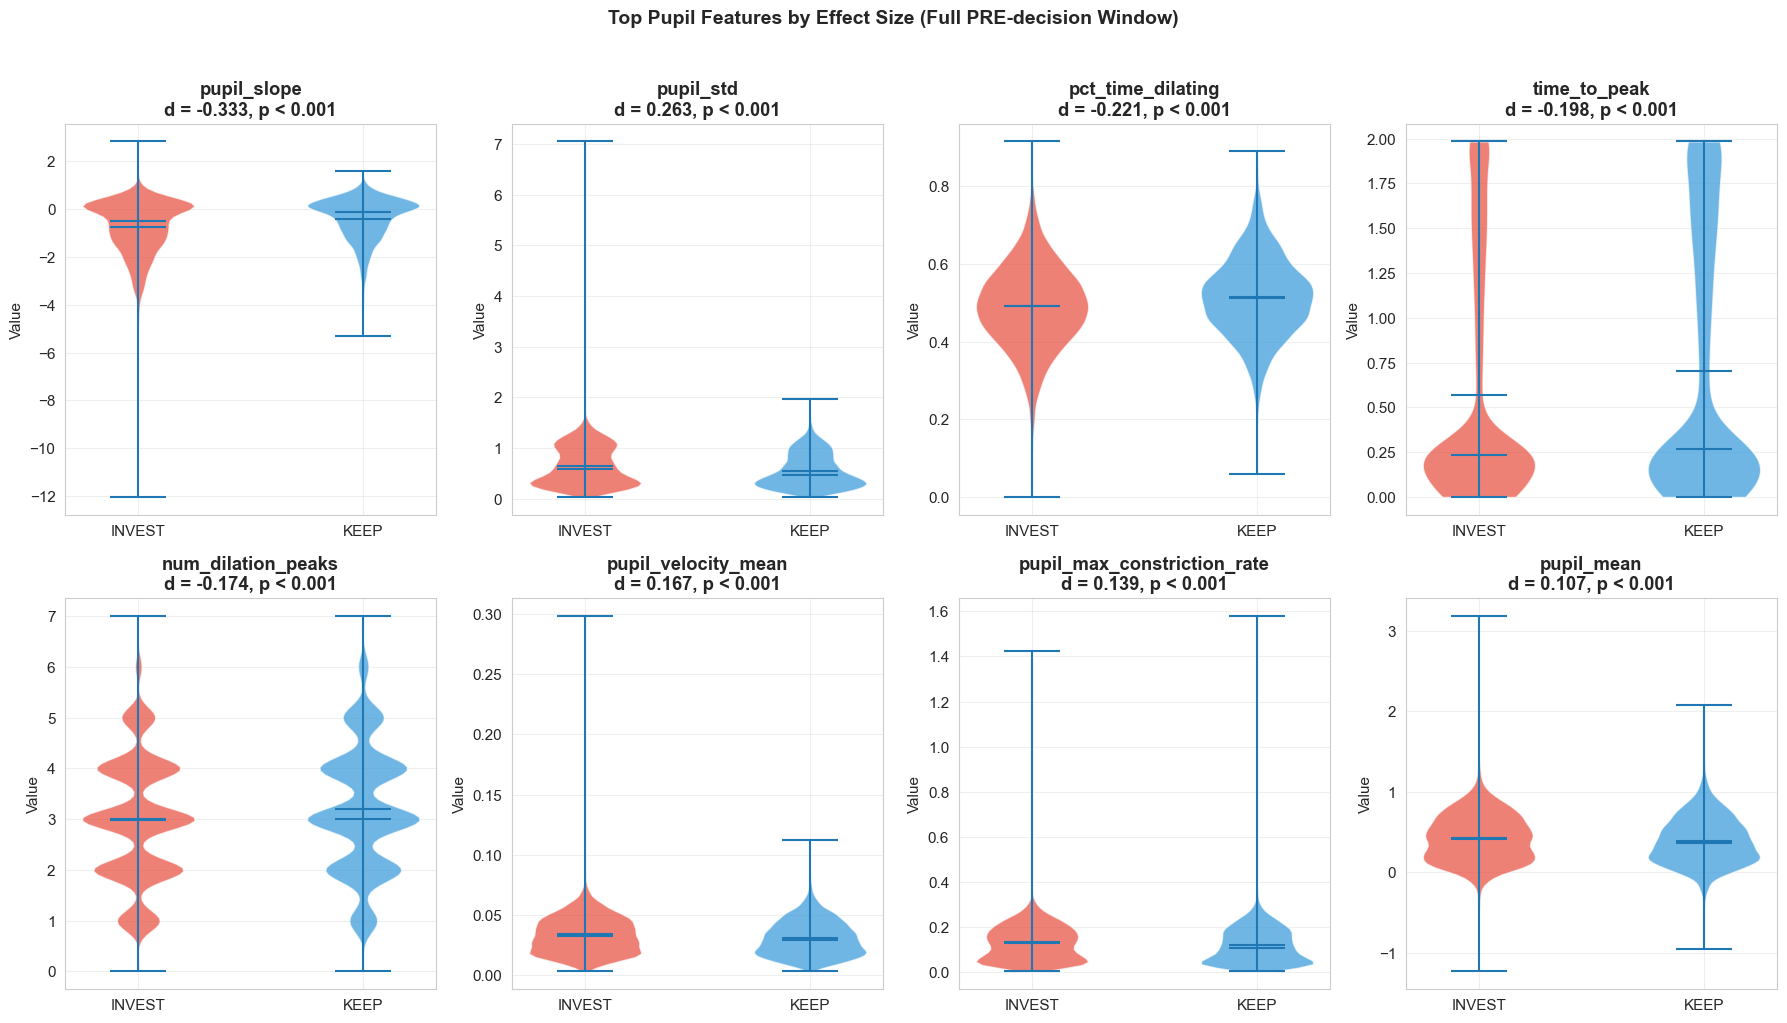

In [27]:
# Visualize top 8 pupil features by effect size
n_features = min(8, len(pupil_comparison_df))
top_features = pupil_comparison_df.head(n_features)['feature_full'].tolist()

fig, axes = plt.subplots(2, 4, figsize=(18, 10))
axes = axes.flatten()

for idx, feature in enumerate(top_features):
    ax = axes[idx]
    
    # Violin plot
    parts = ax.violinplot(
        [invest_trials[feature].dropna(), keep_trials[feature].dropna()],
        positions=[1, 2],
        showmeans=True,
        showmedians=True
    )
    
    # Color the violins
    parts['bodies'][0].set_facecolor('#E74C3C')
    parts['bodies'][0].set_alpha(0.7)
    parts['bodies'][1].set_facecolor('#3498DB')
    parts['bodies'][1].set_alpha(0.7)
    
    ax.set_xticks([1, 2])
    ax.set_xticklabels(['INVEST', 'KEEP'])
    
    # Add effect size and p-value
    row = pupil_comparison_df[pupil_comparison_df['feature_full'] == feature].iloc[0]
    p_val = row['p_value']
    d_val = row['cohens_d']
    sig_text = f"d = {d_val:.3f}, p < 0.001" if p_val < 0.001 else f"d = {d_val:.3f}, p = {p_val:.3f}"
    ax.set_title(f"{feature.replace('_pre', '')}\n{sig_text}", fontweight='bold')
    ax.set_ylabel('Value')
    ax.grid(True, alpha=0.3)

# Hide unused subplots
for idx in range(n_features, 8):
    axes[idx].set_visible(False)

plt.suptitle('Top Pupil Features by Effect Size (Full PRE-decision Window)', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(f'../../data/results/analysis_outputs_{TIMEFRAME}/pupil_all_features_comparison_{TIMEFRAME}.png', 
            dpi=300, bbox_inches='tight')
plt.show()

## ALL Gaze Features Comparison

Analyzing all available gaze features.

In [28]:
# ALL gaze features
gaze_features = [
    'gaze_valid_pct',
    'gaze_x_mean',
    'gaze_x_std',
    'gaze_y_mean',
    'gaze_y_std',
    'screen_x_mean',
    'screen_x_std',
    'screen_y_mean',
    'screen_y_std',
    'gaze_velocity_mean',
    'gaze_velocity_std',
    'gaze_velocity_max',
    'gaze_acceleration_mean',
    'gaze_acceleration_std',
    'fixation_ratio',
    'saccade_ratio',
    'saccade_count',
    'gaze_dispersion_x',
    'gaze_dispersion_y',
    'gaze_path_length',
]

# Compute statistics for all gaze features
gaze_comparison_results = []

for feature in gaze_features:
    if feature not in data_pre.columns:
        continue
        
    invest_vals = invest_trials[feature].dropna()
    keep_vals = keep_trials[feature].dropna()
    
    if len(invest_vals) < 10 or len(keep_vals) < 10:
        continue
    
    # T-test
    t_stat, p_val = stats.ttest_ind(invest_vals, keep_vals)
    
    # Effect size (Cohen's d)
    cohens_d = compute_cohens_d(invest_vals, keep_vals)
    
    gaze_comparison_results.append({
        'feature': feature,
        'invest_mean': invest_vals.mean(),
        'keep_mean': keep_vals.mean(),
        'difference': invest_vals.mean() - keep_vals.mean(),
        't_statistic': t_stat,
        'p_value': p_val,
        'cohens_d': cohens_d,
        'abs_cohens_d': abs(cohens_d),
        'significant': p_val < 0.05,
        'significant_bonferroni': p_val < (0.05 / len(gaze_features))
    })

gaze_comparison_df = pd.DataFrame(gaze_comparison_results)
gaze_comparison_df = gaze_comparison_df.sort_values('abs_cohens_d', ascending=False)

print("\n" + "="*100)
print("ALL GAZE FEATURES: INVEST vs KEEP (Full PRE-decision window: -2s to 0s)")
print("="*100)
print(gaze_comparison_df[['feature', 'invest_mean', 'keep_mean', 'cohens_d', 'p_value', 'significant', 'significant_bonferroni']].to_string(index=False))


ALL GAZE FEATURES: INVEST vs KEEP (Full PRE-decision window: -2s to 0s)
               feature  invest_mean  keep_mean  cohens_d  p_value  significant  significant_bonferroni
         screen_y_mean     0.480945   0.474018  0.070143 0.000200         True                    True
     gaze_dispersion_x     0.264187   0.284576 -0.065483 0.000516         True                    True
     gaze_dispersion_y     0.140355   0.158267 -0.053931 0.004234         True                   False
     gaze_velocity_max    13.543445  15.422987 -0.050820 0.007035         True                   False
            gaze_x_std     0.158012   0.159883 -0.036580 0.052364        False                   False
         screen_x_mean     0.502813   0.505248 -0.036559 0.052498        False                   False
          screen_x_std     0.069547   0.070737 -0.023997 0.203079        False                   False
    gaze_velocity_mean     0.627545   0.588485  0.023610 0.210459        False                   False


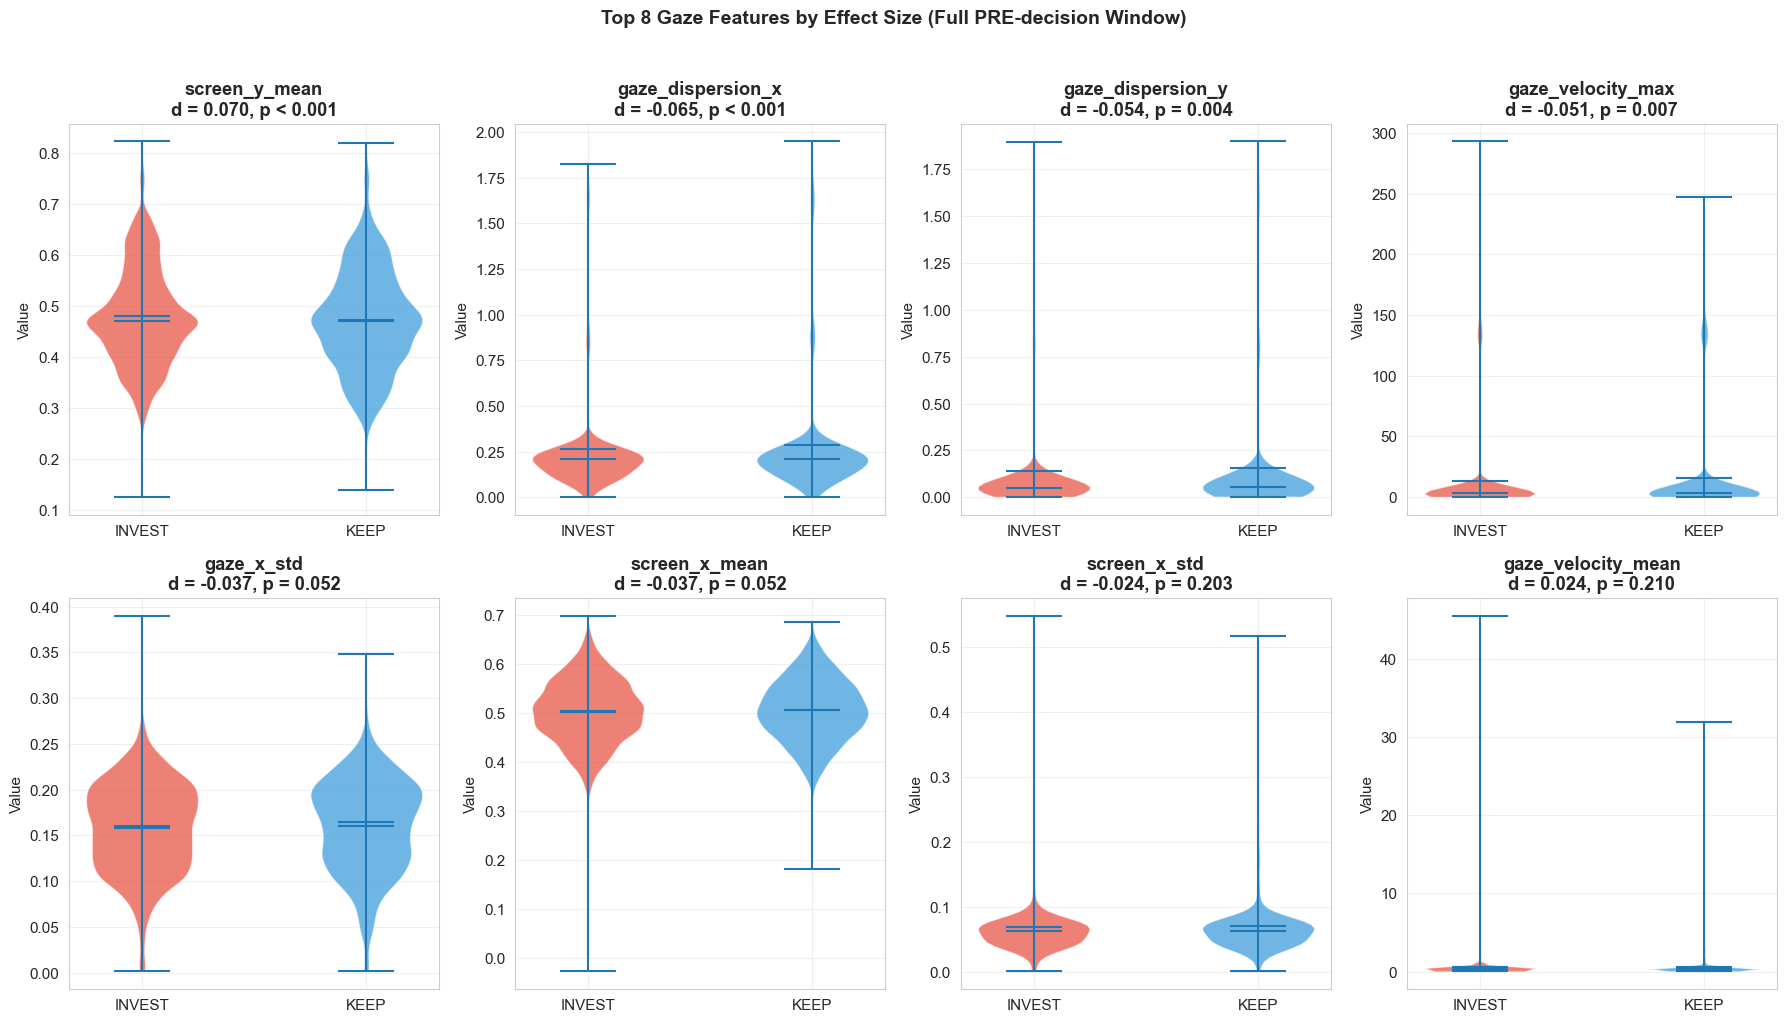

In [29]:
# Visualize top gaze features by effect size
top_gaze = gaze_comparison_df.head(8)['feature'].tolist()

fig, axes = plt.subplots(2, 4, figsize=(18, 10))
axes = axes.flatten()

for idx, feature in enumerate(top_gaze):
    ax = axes[idx]
    
    # Violin plot
    parts = ax.violinplot(
        [invest_trials[feature].dropna(), keep_trials[feature].dropna()],
        positions=[1, 2],
        showmeans=True,
        showmedians=True
    )
    
    # Color the violins
    parts['bodies'][0].set_facecolor('#E74C3C')
    parts['bodies'][0].set_alpha(0.7)
    parts['bodies'][1].set_facecolor('#3498DB')
    parts['bodies'][1].set_alpha(0.7)
    
    ax.set_xticks([1, 2])
    ax.set_xticklabels(['INVEST', 'KEEP'])
    
    # Add effect size and p-value
    row = gaze_comparison_df[gaze_comparison_df['feature'] == feature].iloc[0]
    p_val = row['p_value']
    d_val = row['cohens_d']
    sig_text = f"d = {d_val:.3f}, p < 0.001" if p_val < 0.001 else f"d = {d_val:.3f}, p = {p_val:.3f}"
    ax.set_title(f"{feature}\n{sig_text}", fontweight='bold')
    ax.set_ylabel('Value')
    ax.grid(True, alpha=0.3)

plt.suptitle('Top 8 Gaze Features by Effect Size (Full PRE-decision Window)', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(f'../../data/results/analysis_outputs_{TIMEFRAME}/gaze_all_features_comparison_{TIMEFRAME}.png', 
            dpi=300, bbox_inches='tight')
plt.show()

## Save Results Summary

In [30]:
# Combine all results
all_comparison_df = pd.concat([
    pupil_comparison_df.assign(modality='pupil'),
    gaze_comparison_df.assign(modality='gaze')
], ignore_index=True)

# Sort by absolute effect size
all_comparison_df = all_comparison_df.sort_values('abs_cohens_d', ascending=False)

# Save
output_dir = Path('../../data/results/analysis_outputs_PRE')
output_dir.mkdir(parents=True, exist_ok=True)

all_comparison_df.to_csv(output_dir / f'temporal_dynamics_full_window_{TIMEFRAME}.csv', index=False)

print("\n" + "="*100)
print("FULL WINDOW BASELINE: ALL FEATURES SORTED BY EFFECT SIZE")
print("="*100)
print(all_comparison_df[['feature', 'modality', 'cohens_d', 'p_value', 'significant', 'significant_bonferroni']].head(20).to_string(index=False))
print(f"\n✓ Full results saved to: temporal_dynamics_full_window_{TIMEFRAME}.csv")


FULL WINDOW BASELINE: ALL FEATURES SORTED BY EFFECT SIZE
                    feature modality  cohens_d      p_value  significant  significant_bonferroni
                pupil_slope    pupil -0.332866 6.223602e-69         True                    True
                  pupil_std    pupil  0.263080 6.289924e-44         True                    True
          pct_time_dilating    pupil -0.221143 1.306453e-31         True                    True
               time_to_peak    pupil -0.198181 9.719810e-26         True                    True
         num_dilation_peaks    pupil -0.174200 2.855228e-20         True                    True
        pupil_velocity_mean    pupil  0.166620 1.102819e-18         True                    True
pupil_max_constriction_rate    pupil  0.138989 1.780289e-13         True                    True
                 pupil_mean    pupil  0.106922 1.446817e-08         True                    True
     pupil_acceleration_std    pupil  0.079282 2.624226e-05         T

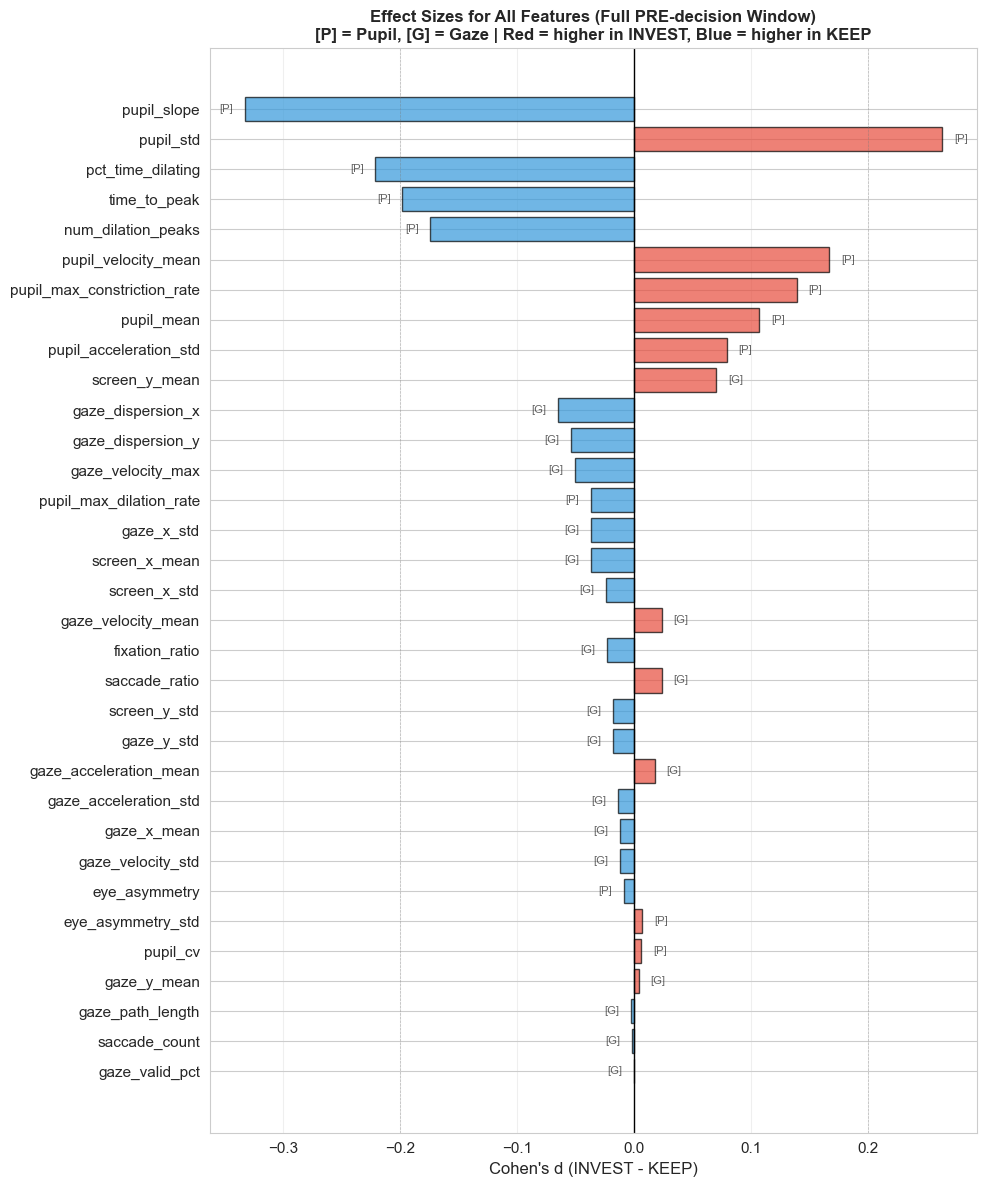


SUMMARY STATISTICS
Total features analyzed: 33
  - Pupil features: 13
  - Gaze features: 20

Significant features (p < 0.05): 14
Significant after Bonferroni: 11

Largest effect: pupil_slope (d = -0.333)


In [31]:
# Create summary heatmap of all features
fig, ax = plt.subplots(figsize=(10, 12))

# Prepare data for heatmap
heatmap_data = all_comparison_df[['feature', 'cohens_d', 'modality']].copy()
heatmap_data = heatmap_data.sort_values('cohens_d', key=abs, ascending=True)

colors = ['#E74C3C' if d > 0 else '#3498DB' for d in heatmap_data['cohens_d']]
y_positions = range(len(heatmap_data))

bars = ax.barh(y_positions, heatmap_data['cohens_d'], color=colors, alpha=0.7, edgecolor='black')

# Add significance markers
for i, (_, row) in enumerate(heatmap_data.iterrows()):
    if row['cohens_d'] > 0:
        x_pos = row['cohens_d'] + 0.01
        ha = 'left'
    else:
        x_pos = row['cohens_d'] - 0.01
        ha = 'right'
    
    # Add modality label
    modality_label = '[P]' if all_comparison_df[all_comparison_df['feature'] == row['feature']]['modality'].values[0] == 'pupil' else '[G]'
    ax.text(x_pos, i, modality_label, ha=ha, va='center', fontsize=8, alpha=0.7)

ax.set_yticks(y_positions)
ax.set_yticklabels(heatmap_data['feature'])
ax.axvline(x=0, color='black', linestyle='-', linewidth=1)
ax.axvline(x=0.2, color='gray', linestyle='--', linewidth=0.5, alpha=0.5)
ax.axvline(x=-0.2, color='gray', linestyle='--', linewidth=0.5, alpha=0.5)

ax.set_xlabel("Cohen's d (INVEST - KEEP)", fontsize=12)
ax.set_title("Effect Sizes for All Features (Full PRE-decision Window)\n[P] = Pupil, [G] = Gaze | Red = higher in INVEST, Blue = higher in KEEP", 
             fontweight='bold', fontsize=12)
ax.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig(output_dir / f'effect_size_all_features_{TIMEFRAME}.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n" + "="*100)
print("SUMMARY STATISTICS")
print("="*100)
print(f"Total features analyzed: {len(all_comparison_df)}")
print(f"  - Pupil features: {len(pupil_comparison_df)}")
print(f"  - Gaze features: {len(gaze_comparison_df)}")
print(f"\nSignificant features (p < 0.05): {all_comparison_df['significant'].sum()}")
print(f"Significant after Bonferroni: {all_comparison_df['significant_bonferroni'].sum()}")
print(f"\nLargest effect: {all_comparison_df.iloc[0]['feature']} (d = {all_comparison_df.iloc[0]['cohens_d']:.3f})")